In [5]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [6]:
file2 = pd.read_csv("Output/BenSummaryJustMatrix.csv")
#Extract useful data
#file2 = file2[file2['Target PPM'] < 100]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']
#Train Test split
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

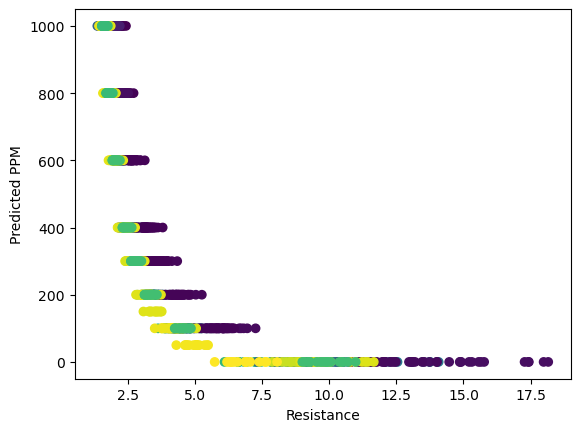

In [7]:
df = file2
plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
plt.show()

Accuracy of equation

0-1000
Resistance: RMSE 111.6
Resistance+Humidity: RMSE 88.1
Resistance+Temperature: RMSE 111.3
Resistance+Humidity+Temperature: RMSE: 87.6

0-500
Resistance: RMSE 60.7
Resistance+Humidity: RMSE 47.9
Resistance+Temperature: RMSE 60.7
Resistance+Humidity+Temperature: RMSE: 44.3

In [8]:
# Funk Equation
def funct3(X, a, b, c, d, e,f,g,h,i,j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
p0 = 1,1,.5,1,1,1,1,1,1,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM,p0, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct3((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct3((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

[ 3.61680882e+01  8.42027049e-01  4.69620665e+00  5.94299585e+00
  7.11595211e-02  4.48341711e+00 -1.40473228e+02  1.96014441e+00
  1.20223315e+01 -6.87866216e+01]
77.16932440624689
The 95% Confidence Interval for 0 is (-7.450911463631387, 11.520683151107031)
The 95% Confidence Interval for 200 is (205.3316187285117, 217.2295856997877)
The 95% Confidence Interval for 400 is (441.5337489360086, 459.7217520140804)
The 95% Confidence Interval for 600 is (613.657934509784, 634.8295150963871)
The 95% Confidence Interval for 800 is (765.4393979084215, 789.0611733045947)
The 95% Confidence Interval for 1000 is (910.9224799718687, 939.9181855309236)


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5670/938967646.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5670/938967646.py:4: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5670/938967646.py:34: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))


R-squared:  0.9428638662875234


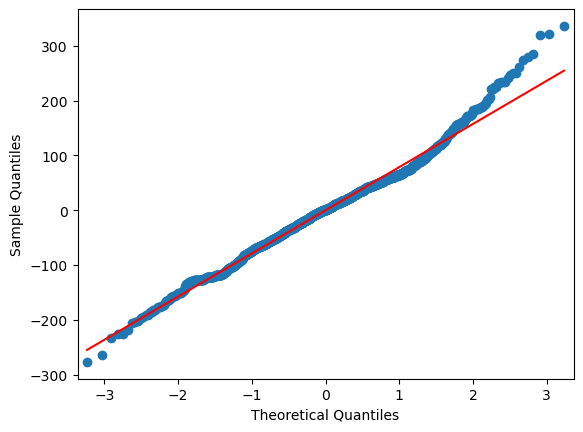

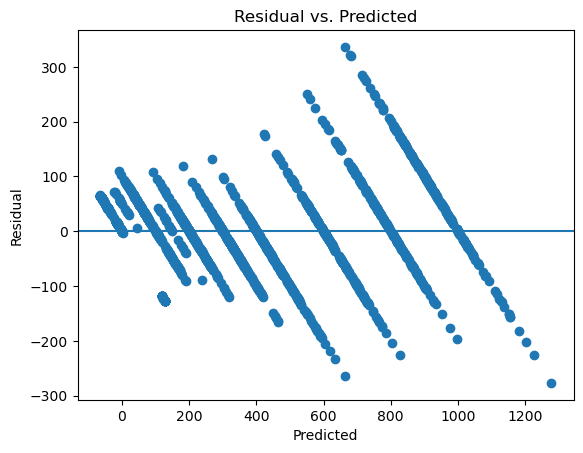

F-statistic: 2974.037797000391
p-value: 0.0


In [9]:
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt


y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


In [10]:
def funct(X, a, b, c, d,e, f,g):
    R, H, T = X
    return a*R**b+c*H**d+e*(T+30)**f+g
p0 = 1,1,.5,1,1,1,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

[-3.07293490e+01 -5.43327266e+01  5.87046097e+02 -2.25964932e-02
 -1.70492364e-03  2.22866297e+00 -1.14270944e+02]
323.01429323188717
The 95% Confidence Interval for 0 is (415.74436016422897, 417.9840676701209)
The 95% Confidence Interval for 200 is (415.7650593557011, 418.2332297780362)
The 95% Confidence Interval for 400 is (416.06955485861465, 418.3618092454442)
The 95% Confidence Interval for 600 is (415.7181207391264, 418.1946142258494)
The 95% Confidence Interval for 800 is (415.55185989336485, 418.0024000491758)
The 95% Confidence Interval for 1000 is (415.7108311217191, 417.9709297068525)


/Users/benfunk/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5670/1048105842.py:33: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))


R-squared:  0.003722679339114965


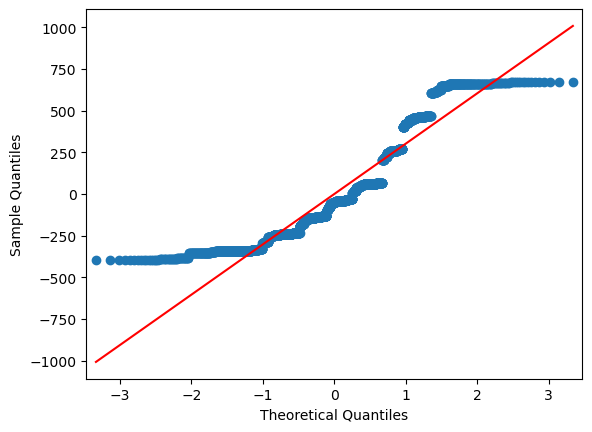

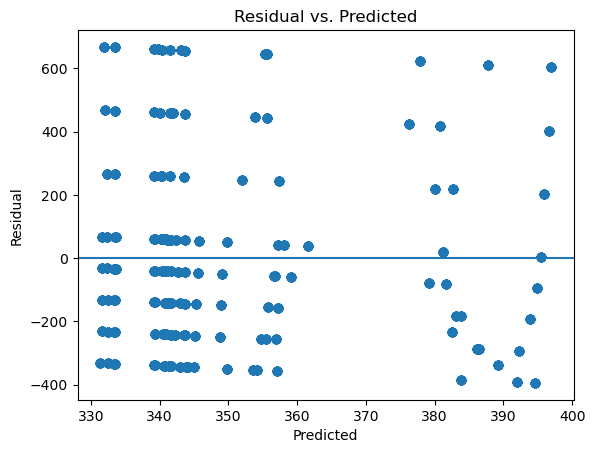

F-statistic: 1.4603837153216614
p-value: 0.18792737345711538


In [11]:
y_pred = funct((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)